# Projet sante publique france

## Déjà réalisé

Les données ont été chargée et ont subit un pré-traitement:
   * Les produits ont tous un nom
   * Certains des produits proviennent d'une source fiable est sont donc considérées comme fiables
   * Les données sont désormais dans un fichier `pickle` dans le dossier `data/interim`
   
## Contenu du notebook

Ce notebook sert juste à télécharger les images depuis le site 
d'openfoodfacts.

In [1]:
from concurrent.futures import ProcessPoolExecutor as PoolExecutor
import io
import os
import warnings

import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import requests
from tqdm import tqdm

In [2]:
def get_image(url, dest_name):
    if os.path.exists(dest_name):
        return 0
    response = requests.get(url)
    if response.status_code != 200:
        warnings.warn('Error %i ' % response.status_code)
    else:
        try:
            img = Image.open(io.BytesIO(response.content))
            img.save(dest_name)
        except OSError as e:
            warnings.warn(e)

In [3]:
def download_product_picts(urls, destination='../data/raw/picts/products/', **kwargs):
    actual = kwargs.get('actual')
    total = kwargs.get('total')
    if not os.path.exists(destination):
        os.makedirs(destination)
    with PoolExecutor(max_workers=32) as executor:
        if total and actual:
            t = tqdm(total=total)
            t.update(actual)
        else:
            t = tqdm(total=len(list(urls)))
        names = [f'{destination}prod_{x}.png' for x in urls.index.values]
        for _ in executor.map(get_image, list(urls), names):
            t.update()
        t.close()

In [4]:
def show_random_pict(products):
    products = products.index.values
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
    k = 0
    for i in range(5):
        for j in range(5):
            ax = axes[i, j]
            path = f"../data/raw/picts/products/prod_{products[k]}.png"
            ax.imshow(Image.open(path))
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.title.set_text(f'prod_{products[k]}')
            k += 1
    plt.show()

On recharge les données 

In [5]:
# On récupère les données du premier traitement
data = pd.read_pickle('../data/interim/products_interim.pickle')

On retire les produits pour lesquels on a pas de photo.

In [6]:
data.drop(data[data['image_url'].isna()].index, axis=0, inplace=True)

On télécharge les photos des produits

In [7]:
data['downloaded'] = data.index.map(lambda x : os.path.exists(f"../data/raw/picts/products/prod_{x}.png"))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    total = data.shape[0]                                                    
    to_download = data.drop(data[data['downloaded']].index, axis=0)
    actual = total - to_download.shape[0]                                                       
    download_product_picts(to_download["image_url"], total=total, actual=actual)

100%|██████████| 536767/536767 [00:02<00:00, 251603.87it/s]


On télécharge les photos des tables nutritionnelles

In [8]:
data.drop(data[data['image_nutrition_url'].isna()].index, axis=0, inplace=True)
data['downloaded_nutri'] = data.index.map(lambda x : os.path.exists(f"../data/raw/picts/nutrition/prod_{x}.png"))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    total = data.shape[0]
    to_download = data.drop(data[data['downloaded_nutri']].index, axis=0)
    actual = total - to_download.shape[0]
    download_product_picts(to_download['image_nutrition_url'].dropna(axis=0), total=total, actual=actual, destination='../data/raw/picts/nutrition/')

100%|██████████| 196242/196242 [00:02<00:00, 82682.34it/s] 


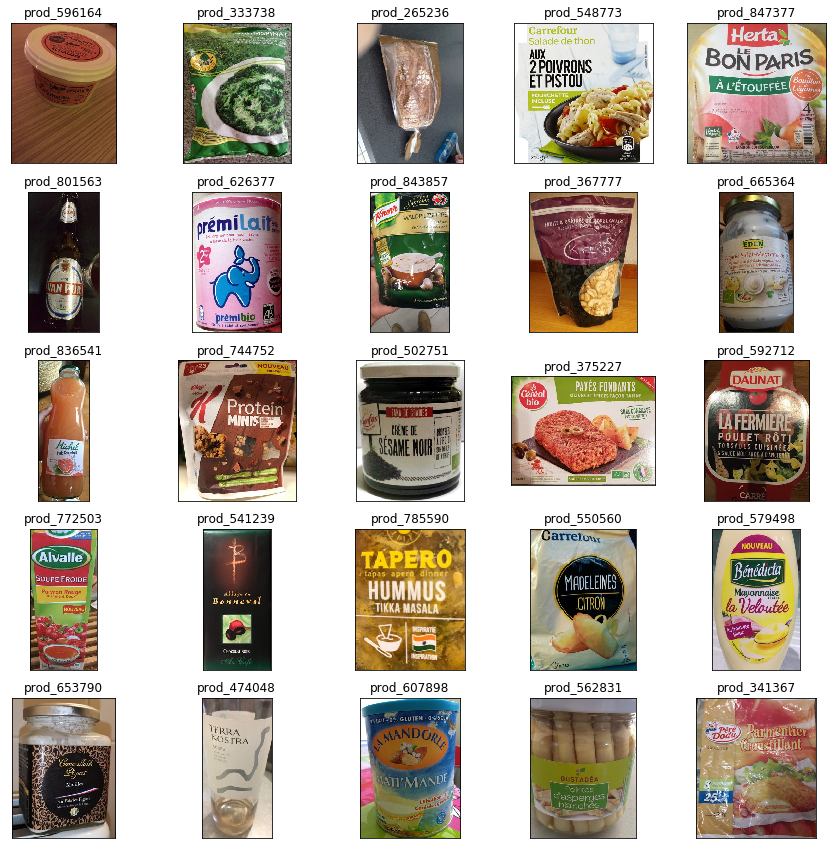

In [9]:
products = data["downloaded"].sample(n=25)
show_random_pict(products)

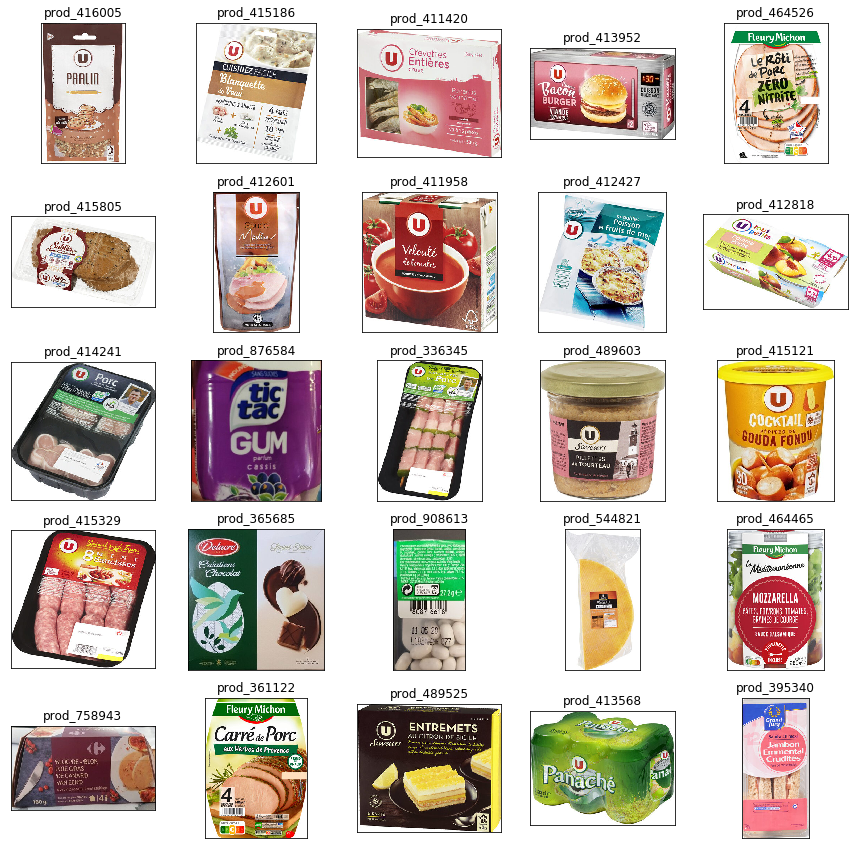

In [10]:
products = data[data["trusted_src"]]["downloaded"].sample(n=25)
show_random_pict(products)